# Quantum binary adder

We are inspired by [this tutorial](https://medium.com/@sashwat.anagolum/arithmetic-on-quantum-computers-addition-7e0d700f53ae), but our implementation is slightly different.

In [1]:
from qiskit import *
from qiskit.visualization import *
import numpy as np

## How to add in binary

This works just like what we learned in elementary school:

1. Lay the numbers represented in binary one above the other. For example the numbers `21` and `26` are in binary `10101` and `11010` respectively
1. Sum each column from right to left below the line
1. If the sum requires two digits (bits) to represent, carry the left bit (at the `10`s place) to the next column and place the right bit (at the `1`s place) under the line

In the image, the numbers `21` and `26` are added together in binary. The digit in orange represents the only carry bit that is `1`. The sum is `101111` which is `47` in decimal.

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/binary_add.png">

## Binary addition of two bits

Adding two binary digits (bits) with logic gates is easy. The sum can be computed with a single exclusive OR operation and a single AND of the bits.

Exclusive OR, which is called `XOR` for short does the following:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/xor.png">

The `AND` operation:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/and.png">

The result (i.e. the output) of the `XOR` operation is called the _sum_ and the result of the `AND` operation is called the _carry_.

## Half adder

When we combine the output of these two gates we get a _half adder_, which takes two bits and computes their _sum_ and _carry_:

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/half_adder.png">

## Carry

The result from `A AND B` is called the _carry_ bit because it is used to carry the overflow from the summation to the next one. However the next adder now needs to add three bits: `A + B + C` in order to include the carry bit from the previous computation. This is why we need to create a binary adder for three bits which is called a full adder.

> **Note:** The carry bit is on if and only if there was overflow in the summation. The terms _carry_ and _overflow_ are therefore used interchangeably.

Before diving in to the full adder let's see how we could use two half adders for adding two two-bit numbers together and where it would fail. We will ignore the carry bits as there is no way to take them into account with the half adders.

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/success.png">

When the addition of the individual digits never overflows, the carry is 0 and the sum is correct: $1 + 2 = 3$. However if there is overflow, the carry is not zero and the sum is incorrect:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/fail.png">

$1 + 3 = 2$ is false.

We simply need more adding capabilities to include the carry bits in the calculation.

## Full adder

A _full adder_ takes three bits `A`, `B` and `C` as input and outputs two bits `CARRY` and `SUM`. The half adder only took two bits as input. The full adder solves our problem, where with a half adder we could not include the carry bits in the calculation.

The full adder operates like this:

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/full_adder.png">

A full adder can be made from two half adders and an OR gate. With $N$ full adders we can finaly add any two $N$-digit binary number together. Here's what it looks like:


`A = 10101` (21 in decimal) and `B = 10111` (23 in decimal) are added together. The carry output from each column's full adder is moved over to the `C` input of the next columns. Each column requires one full adder except for the rightmost one.

> If there was something to carry from the leftmost column, we would have what's called _integer overflow_.

The sum of the numbers is in the `SUM` register.

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/full_example.png">

## Quantum addition

Next we will create a quantum full adder which works exactly like its classical counterpart. Before we can create the circuit, we need to define how we represent bits on a quantum computer.

> As you might have guessed, using one qubit to represent one bit is very inefficient.

## Representing bits with qubits

A qubit can be used to represent a binary digit with for example these two pure states: $|0\rangle$ or $|1\rangle$. A $|0\rangle$ state represent `0` in binary and $|1\rangle$ represents `1`. All binary operators can be created using quantum gates. For now we only consider pure states, which are deterministic and are not in a superposition.

For example the classical `NOT` operator can be represented by the $X$ gate. The $Y$ gate would also work.

### Exercise 1

Run the following code and write to the prompt `0` or `1` to see what its logical `NOT` is.

In [ ]:
qc = QuantumCircuit(1)

state = int(input('Write 1 or 0: '))

qc.initialize(state, 0)
qc = qc.decompose()
qc.barrier() # visual separation

qc.x(0)

qc.measure_all()
display(qc.draw(output='mpl'))

backend = Aer.get_backend('aer_simulator')
output = next(iter(backend.run(qc).result().get_counts().keys()))
print(f"NOT {state} = {output}")

## `XOR` with $CX$ gates

With a controlled $X$ gate (a $CX$) we can achieve the following truth table with qubits in basis states $|0\rangle$ or $|1\rangle$:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/xor.png">

The following quantum circuit can be observed to have identical behavior.

### Exercise 2

Run the following code and input two bits e.g. `01` in the prompt and write the answer below. Do the same for all four combinations of two bits.

In [ ]:
qc = QuantumCircuit(2, 1)

states = int(input('Write two bits: '), 2)

qc.initialize(states, [1, 0])
qc = qc.decompose()
qc.barrier()

qc.cx(0, 1)

qc.measure(1, 0)
display(qc.draw(output='mpl'))

backend = Aer.get_backend('aer_simulator')
output = next(iter(backend.run(qc).result().get_counts().keys()))
print(f"{states // 2} XOR {states % 2} = {output}")

Write the answers to exercise 2 here:
- `0 XOR 0` = TODO
- `0 XOR 1` = TODO
- `1 XOR 0` = TODO
- `1 XOR 1` = TODO

The circuit always calculates the exclusive OR result to the qubit that is the target of the $CX$. The control qubit is left unchanged.

## `AND` gate

The quantum `AND` gate is a bit more tricky as it cannot store the result to one of the input qubits like the `XOR` does.

<details open>
<summary>No-AND theorem proof</summary>

<blockquote>

### Why a two qubit `AND` gate cannot exist?

The truth table for an (impossible) `AND` gate would be

$$
\begin{align}
AND |ab\rangle &= |cd\rangle \\
\hline
AND |00\rangle &= |00\rangle \\
AND |01\rangle &= |00\rangle \\
AND |10\rangle &= |10\rangle \\
AND |11\rangle &= |11\rangle
\end{align}
$$

where $AND$ is a $4×4$ matrix, $a$ and $b$ are the input qubits and $d$ is $1$ if and only if both $a$ and $b$ are $1$.

> In the quantum circuit you can think that $|ab\rangle$ is the input to the gate and $|cd\rangle$ is the output.

We observe that the output state $|00\rangle$ is the outcome of two input states: $|00\rangle$ and $|01\rangle$. The following picture describes the $AND$ gate as a function:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/and_set.png">

The inverse of this function, namely $AND^{-1}$, would look like the following:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/and_inv_set.png">

Which is impossible to define, and thus the inverse does not exist. For the $AND$ matrix to be unitary, the following equation must be true:

$$
AND\ AND^{-1} = I
$$

Therefore, as $AND^{-1}$ does not exist, $AND$ is not unitary.
</blockquote>
</details>

## Toffoli gate

The $CCX$ gate, also known as the Toffoli gate, is the $AND$ gate we need. It operates on three qubits flipping the target if and only if the control qubits are $1$.

<h3 id="Exercise-3">Exercise 3</h3>

Run the following code to see how the measurement of $q_2$ resulted in the binary `AND` operation of $q_0 \land q_1$.

Modify the circuit to implement a quantum $OR$ gate. (Hint: all you need to add are $X$ gates)

00 --> 0
01 --> 0
10 --> 0
11 --> 1


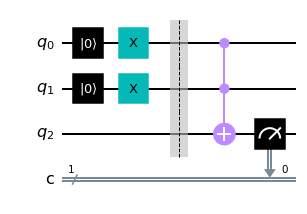

In [2]:
states = ['00', '01', '10', '11']

for s in states:
    qc = QuantumCircuit(3, 1)

    qc.initialize(int(s, 2), [1, 0])
    qc.barrier()
    qc = qc.decompose()

    # TODO implement the OR gate
    qc.ccx(0, 1, 2)

    qc.measure(2, 0)

    backend = Aer.get_backend('aer_simulator')
    output = next(iter(backend.run(qc).result().get_counts().keys()))
    q2 = output[0] # first bit in the register is the last qubit that was measured
    print(s, '-->', q2)

display(qc.draw(output='mpl'))

## Optional material: No cloning

It is worth pointing out that the input in this circuit is not always available after the gates as it is impossible to clone arbitrary qubits. This restriction also requires us to use ancillas in our addition circuit.

<details>
<summary>Click here to show a proof of the no-cloning theorem</summary>
<blockquote>
Suppose we have a quantum gate $U$ which operates on two qubits: the first ($\psi$ or $\phi$) is the qubit to clone and the second ($s$) is the target to clone to.

For all single qubit states $\psi$ and $\phi$ and some qubit $s$ the following equations must hold for the clone gate $U$:

$$
U |\psi s\rangle = |\psi\psi\rangle \\
U |\phi s\rangle = |\phi\phi\rangle
$$

We shall take the Hermitian adjoint of both sides of the second equation:

$$
U |\psi s\rangle = |\psi\psi\rangle \\
\big(U |\phi s\rangle\big)^\dagger = \big(|\phi\phi\rangle\big)^\dagger
$$

And multiply the corresponding sides of the equations together in the order that calculates their inner product (row vector first):

$$
\Rightarrow \big(U |\phi s\rangle\big)^\dagger U |\psi s\rangle = \big(|\phi\phi\rangle\big)^\dagger |\psi\psi\rangle
$$

<blockquote>
A quick note about the Hermitian adjoint: Taking the Hermitian adjoint of a matrix product applies it to all matrices and reverses the order of the matrices. For example:

$$
\big(ABC\big)^\dagger = C^\dagger B^\dagger A^\dagger
$$
</blockquote>

Simplifying the equation gives us:

$$
\Leftrightarrow |\phi s\rangle^\dagger U^\dagger U |\psi s\rangle = |\phi\phi\rangle^\dagger |\psi\psi\rangle
$$

Due to the associativity of matrix multiplication and unitarity of $U$ we can write $U^\dagger U = I$ and omit it from the equation:

$$
\Leftrightarrow |\phi s\rangle^\dagger |\psi s\rangle = |\phi\phi\rangle^\dagger |\psi\psi\rangle
$$

Let's express some of the two-qubit states with a tensor product

$$
\Leftrightarrow \big(|\phi\rangle \otimes |s\rangle\big)^\dagger |\psi s\rangle = \big(|\phi\rangle \otimes |\phi\rangle \big)^\dagger |\psi\psi\rangle
$$

<blockquote>
A quick note about the Hermitian adjoint operating on a tensor product: The Hermitian adjoint applies to all matrices but the order of the product stays the same. For example:

$$
|abc\rangle^\dagger
= \big(|a\rangle \otimes |b\rangle \otimes |c\rangle\big)^\dagger
= |a\rangle^\dagger \otimes |b\rangle^\dagger \otimes |c\rangle^\dagger
= \langle a| \otimes \langle b| \otimes \langle c| = \langle abc |
$$
</blockquote>

$$
\Leftrightarrow \langle \phi s |\psi s\rangle = \langle \phi\phi|\psi\psi\rangle
$$

<blockquote>
And a quick not about the tensor product: Taking a matrix product of two tensored matrices is the same as taking the tensor product of the respective matrices multiplied together. For example:

$$
\big(A\otimes B\big)\big(C\otimes D\big) = AC \otimes BD \\
\langle ab|cd\rangle = \big(\langle a|\otimes\langle b|\big)\big(|c\rangle\otimes|d\rangle\big) = \langle a|c\rangle\otimes\langle b|d\rangle
$$

> Also note that the precedence of the tensor product is undefined but generally lower than that of (matrix) multiplication.
</blockquote>

$$
\Leftrightarrow \langle\phi|\psi\rangle \otimes \langle s|s\rangle = \langle \phi|\psi\rangle \otimes \langle \phi|\psi\rangle
$$

Taking the tensor product of $1×1$ matrices is basically the same as scalar multiplication. Also, as $s$ is a normalized vector, taking an inner product with itself will be unit:

$$
\langle s|s\rangle = 1
$$

$$
\Leftrightarrow \langle\phi|\psi\rangle = \big(\langle \phi|\psi\rangle\big)^2 \\
\Leftrightarrow \langle\phi|\psi\rangle \in \big\{0, 1\big\}
$$

This means the the two qubit state $|\phi\rangle$ and $|\psi\rangle$ cannot be arbitrary as they must be orthogonal or the same state, therefore a generic cloning gate $U$ does not exist.

### "Cloning" gates do exist

However specialized cloning gates do exist. It is very easy to create a gate which can clone a $|0\rangle$ qubit or a $|1\rangle$ qubit. This is possible because the states are orthogonal (their inner product is 0). A gate which can do this is just the $CX$ gate controlled by the qubit to be cloned.

But now you might wonder why it can't clone superpositions even though it is linear: if it clones $|0\rangle$ and $|1\rangle$ perfectly, why couldn't it clone a mix of them? The reason is that the original qubit and the target might get entangled. For example cloning a qubit in the $|+\rangle$ state gets entangled with a qubit in the $|0\rangle$ state in the $CX$ gate. It's not useful to have a cloned qubit which is entangled with the original, because operating on the other changes the other or measuring the other collapses the state of the other.

The following picture "clones" the upper qubit to the lower qubit, but after measuring the lower qubit the upper qubit is no longer in a superposition: $|+\rangle$ has collapsed to $|1\rangle$.

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/entanglement.png">

> **Note:** The picture describes one of two outcomes of the circuit. They can both be $|0\rangle$ too. **Note 2:** The blue arrow does not indicate a transfer of any information.
</blockquote>
</details>

## Quantum addition of two qubits

Next we will create the half adder in a quantum circuit. Remember that our qubits represent binary digits using two states: $|0\rangle$ and $|1\rangle$, superposition is not taken into account yet.

A half adder adds two bits and indicates overflow with the carry bit. A quantum half adder adds two qubits and indicates overflow with the carry qubit.

A classical half adder consists of a `XOR` gate and an `AND` gate. Here is a quantum half adder consisting of a $CX$ gate and a $CCX$ gate:

In [ ]:
states = ['00', '01', '10', '11']

half_adder = QuantumCircuit(QuantumRegister(1, 'a'),
                            QuantumRegister(1, 'b'),
                            QuantumRegister(1, 'c'), name='H') # H for Half
half_adder.ccx(0, 1, 2)
half_adder.cx(0, 1)

results = ""
for s in states:
    a = QuantumRegister(1, 'a')
    b = QuantumRegister(1, 'b')
    carry = QuantumRegister(1, 'carry')
    x = ClassicalRegister(2, 'x')
    qc = QuantumCircuit(a, b, carry, x)

    qc.initialize(int(s, 2), [1, 0])
    qc.barrier()

    qc.append(half_adder, [a, b, carry])
    qc = qc.decompose()

    qc.barrier()
    qc.measure(b, x[0])
    qc.measure(carry, x[1])

    backend = Aer.get_backend('aer_simulator')
    output = next(iter(backend.run(qc).result().get_counts().keys()))

    sum_ = output[1]
    carry = output[0]
    results += f"\n{s[0]} {s[1]} --> {carry:>5} {sum_:>3}"

display(qc.draw(output='mpl'))

print(f'A B --> CARRY SUM{results}')

From the output we can observe the $b$ qubit to be in the state which represents the sum of $a$ and $b$ and the $carry$ qubit to be in the state which represents overflow of the sum.

The output of $a$ is not used and doesn't need to be measured.

## Full adder continued

To create a full adder we can use two half adders like in the following block diagram:

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/adder_block.png">

`H` is a half adder and `OR` is a logical OR gate. However the `OR` gate can be switched out for a `XOR` gate because both adders can't overflow at the same time.

<h2 id="Quantum-full-adder">Quantum full adder</h2>

The quantum full adder can be created using the following quantum circuit:

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/adder_quantum.png">

The $H$ gate is a `half_adder` which is created using the same circuit as seen in the previous code block. The $XOR$ gate is the same $CX$ gate from [exercise 3](#Exercise-3).

> The quantum full adder will require an extra qubit for each half adder because there is no two-qubit `AND` gate. Otherwise we could use the first qubit to store the carry and the second to store the sum.

### Exercise 4

Implement a full adder in the following quantum circuit using two `half_adder`s and a `XOR` gate.

In [ ]:
a = QuantumRegister(1, 'a')
b = QuantumRegister(1, 'b')
c = QuantumRegister(1, 'c')
d = QuantumRegister(1, 'd')
e = QuantumRegister(1, 'e')

full_adder = QuantumCircuit(a, b, c, d, e, name='F')

# change the initialization state to test your circuit:
# '110' means initialize a = 1, b = 1, c = 0
state = '110'

# TODO implement the quantum full adder here
full_adder.append(half_adder, [a, b, c]) # example of adding a half_adder, change qubits if needed



display(full_adder.draw(output='mpl'))

print('Decomposed version of the full adder:')
display(full_adder.decompose().draw(output='mpl'))

# The following lines are used to set up a quantum circuit which uses your full_adder
qc = QuantumCircuit(5)
qc.initialize(int(state, 2), [2, 1, 0])
qc.append(full_adder, range(5))
qc = qc.decompose()
qc.measure_all()
backend = Aer.get_backend('aer_simulator')
output = next(iter(backend.run(transpile(qc, backend)).result().get_counts().keys()))

a = output[4] # junk
b = output[3] # junk
c = output[2] # final sum
d = output[1] # junk
e = output[0] # carry

print("A + B + C --> carry sum = 2*carry + sum")
print(f"{state[0]} + {state[1]} + {state[2]} --> {e:>5} {c:>3} = {2 * int(e, 2) + int(c, 2)}")

### Exercise 4 tests

Run the following code to see if your circuit works like expected.

> **Note:** You will need a working full adder for the next exercise!

In [ ]:
from tests import full_adder_tests

passed = full_adder_tests(full_adder).run()

if passed: print("Congratulations, all tests passed!")
else: print("The full adder is not working like it should. Try to find what goes wrong using the test results above.")

## Quantum binary adder

We finally have all the pieces ready, the `half_adder` and the `full_adder` gates, to start chaining them to create a quantum binary adder of arbitrary size.

### Binary adder of 3-bit numbers

To hammer home the addition algorithm quantum or classical I created the following block diagram. In the diagram adders are chained together to create an adder for two 3-bit numbers `000..111`:

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/adder3_block.png">

> **Note:** The chained adder is not a six bit adder in the same sense that the half adder adds two bits and full adder three. The chained adder takes into account the position of each bit (which represents the _nth_ power of two) unlike half and full adders. **Note 2**: The output number is 4 bits long if we include the last carry bit as the most significant bit.

The input numbers are represented with $a$ and $b$ and the output result sum is $x = a + b$, and the gates $H$ and $F$ stand for half and full adders respectively.

### Exercise 5

Implement the 3-digit binary adder shown above on a quantum circuit. Use `half_adder` and `full_adder` subcircuits.

The number of qubits is already defined correctly. Your task is to append a `half_adder` and two `full_adders`. Then measure the correct output qubits based on the [quantum full adder](#Quantum-full-adder) to the `x` register. `b[0] -> x[0]` is already measured correctly.

In [ ]:
a = QuantumRegister(3, 'a')
b = QuantumRegister(3, 'b')
carry = QuantumRegister(3, 'carry')
ancilla = QuantumRegister(2, 'ancilla') # both full adders require one ancilla for the final XOR
x = ClassicalRegister(4, 'x')

A = '000'
B = '001'

adder = QuantumCircuit(a, b, carry, ancilla, x)

adder.append(half_adder, [a[0], b[0], carry[0]])
# TODO implement the rest of the quantum 3 digit binary adder



adder.barrier()
adder.measure(b[0], x[0]) # this measures the first sum from the half adder correctly
# TODO measure the rest of the outputs from top to bottom



display(adder.draw(output='mpl'))

# The following lines set up a temporary circuit for the adder
qc = QuantumCircuit(11, 4)
qc.initialize(int(A, 2), range(0, 3))
qc.initialize(int(B, 2), range(3, 6))
qc.append(adder, range(11), range(4))
qc = qc.decompose()
backend = Aer.get_backend('aer_simulator')
output = next(iter(backend.run(transpile(qc, backend)).result().get_counts().keys()))
print(f"{A} ({int(A, 2)}) + {B} ({int(B, 2)}) = {output} ({int(output, 2)})")

### Exercise 5 tests

Run the following code to see if your circuit works like expected.

In [ ]:
from tests import adder3_tests

passed = adder3_tests(adder).run()

if passed: print("Congratulations, all tests passed!")
else: print("The 3 bit adder is not working like it should. Try to find what goes wrong using the test results above.")

## Optimization

We can optimize the circuit and reduce the number of qubits with _uncomputation_. This way we can reuse ancillas between gates.

### Uncomputation

[Uncomputation](https://en.wikipedia.org/wiki/Uncomputation) is used to revert ancillary qubits back to their original state, in our case $|0\rangle$. After each full adder we can restore the ancilla in order to use it in the next full adder. This way we only need one ancilla no matter how many bits are in our numbers.

> The non-optimized version used $N - 1$ ancillas.

### Full adder uncomputation

The quantum full adder has the following circuit:

<img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/full_adder_quantum.png">

The three first tracks represent the inputs and the last track represents the overflow of the output. The second to last track is for the ancilla we are interested in.

> This is the quantum gate diagram of the full adder as a reminder:
> <img style="display: block;margin-left: auto;margin-right: auto;width: 30%" src="images/adder_quantum.png">

Uncomputation happens by putting inverses of gates in the inverse order. The $CCX$ and $CX$ gates are Hermitian so they are their own inverse gate.

Our task is to flip the $|d\rangle$ qubit back to $|0\rangle$. To do that we need can add a Toffoli between $a$ $b$ and $d$:

<img style="display: block;margin-left: auto;margin-right: auto;width: 60%" src="images/uncomputation.png">

The problem is that for the added Toffoli to do the inverse of the first one, it must operate under the same conditions. That is not the case because there is a $CX$ flipping $b$ if $a = 1$.

> It's worth to point out that the other $CCX$ and $CX$ gates will cause entanglement issues if the qubits are not in pure basis states. However we assume they are and need not to worry about them entanglements.

### Exercise 6

Uncompute $|d\rangle$ back to state $|0\rangle$ using a $CX$ and a $CCX$ gate:

In [ ]:
a = QuantumRegister(1, 'a')
b = QuantumRegister(1, 'b')
c = QuantumRegister(1, 'c')
d = QuantumRegister(1, 'd')
e = QuantumRegister(1, 'e')

uncomputeD = QuantumCircuit(a, b, c, d, e, name='F')

# change the initialization state to test your circuit:
# '110' means initialize a = 1, b = 1, c = 0
state = '110'

uncomputeD.append(full_adder, [a, b, c, d, e])
uncomputeD = uncomputeD.decompose().decompose()

# TODO uncompute d


display(uncomputeD.draw(output='mpl'))

# The following lines set up a temporary circuit for testing uncomputeD
qc = QuantumCircuit(5)
qc.initialize(int(state, 2), [2, 1, 0])
qc.append(uncomputeD, range(5))
qc = qc.decompose()
qc.measure_all()
backend = Aer.get_backend('aer_simulator')
output = next(iter(backend.run(transpile(qc, backend)).result().get_counts().keys()))

a = output[4] # junk
b = output[3] # junk
c = output[2] # final sum
d = output[1] # should be 0
e = output[0] # carry

print("A B C 0 --> a b c d")
print(f"{state[0]} {state[1]} {state[2]} 0 --> {a} {b} {c} {d}")

### Exercise 6 tests

Run the following code to test if your circuit works as expected and does not change the $|d\rangle$ qubit.

In [ ]:
from tests import uncomputeD_tests

passed = uncomputeD_tests(uncomputeD).run()

if passed: print("Congratulations, all tests passed!")
else: print("The 3 bit adder is not working like it should. Try to find what goes wrong using the test results above.")

## The general quantum adder

The following code block contains a generalized algorithm for creating any $N$ bit quantum adder.

### Exercise 7

Run the following program. Try to find maximum $N$ before your system memory runs out.

In [ ]:
A = int(input('Enter a decimal number: A = '))
B = int(input('Enter another decimal number: B = '))

N = int(np.log2(max(A, B))) + 1

a = QuantumRegister(N, 'a')
b = QuantumRegister(N, 'b')
carry = QuantumRegister(N, 'carry')
ancilla = QuantumRegister(1, 'ancilla')
x = ClassicalRegister(N + 1, 'x')

qc = QuantumCircuit(a, b, carry, ancilla, x)
print(f"Quantum circuit (for N = {N}) uses {len(qc.qubits)} qubits")

qc.initialize(A, range(0, N))
qc.initialize(B, range(N, 2 * N))

# Half adder for adding the least significant bits as there is no third carry bit from previous adder
qc.append(half_adder, [a[0], b[0], carry[0]])

for n in range(1, N):
    qc.append(uncomputeD, [a[n], b[n], carry[n - 1], ancilla, carry[n]])

qc = qc.decompose()
display(qc.draw(output='mpl', fold=-1))

qc.barrier()

# Measures sum from the half adder
qc.measure(b[0], x[0])

# Loop until N + 1 as the last carry bit is the most significant bit in x
for n in range(1, N + 1):
    qc.measure(carry[n - 1], x[n])

qc = qc.decompose()
backend = Aer.get_backend('aer_simulator')
output = next(iter(backend.run(transpile(qc, backend)).result().get_counts().keys()))
print(f"{A} + {B} = {output} ({int(output, 2)})")

### Exercise 7 answer

System memory runs out at $N = TODO$